##  1. Basic Thoughts Before Start
Tier 1
- Create an app that reads the data and creates a classifier model, then takes 6 command line inputs and outputs a prediction result. The app must be able to generate the model from the training data with the code submitted. It must work offline, and it must not take any inputs other than the data.
- Output overall precision, recall, f-score for the trained model.
- Provide some documentation in a readme file of how to install and run your app.

Thoughts 1
- Multi-class Classification Problem
- Input: Features(pagesCount,wordCount,fileSize,author,title,createdDate)
  Output: Lables (five classes)
- Problems: mix data type (numerical & text)
  Solutions： convert text into vectors
  
Tier 2
- Output a confusion matrix after training.
- Output individualised precision, recall, f-score measures for each classification category (legal, sales, etc)

Thoughts 2
- Python libary sklearn metrics

Tier 3
- Prevent the model overfitting the training data and ensure the model generalises to unseen data. Please explain how you achieve this in a readme file. A brief explanation is fine.

Thoughts 3
- Cross Validation

Tier 4
- Pre-process the data to enhance classification accuracy

Thoughts 4
- remove non-alphabetic characters(punctuation, digits)
- unify title (Mister, Mr)
- convert strings into lowercase
- text Stemming and Lemmatizing
- normalization for numerical features

Tier 5
- Try various different classifiers and give their scores in a readme. Explaining why the best classifier succeeds where other classifiers fail.

Thoughts 5
- LSTM, SVM, Navie Bayes, KNN, Random Forest, Adaboost etc.

Tier 6
- Provide an explanation of which features in the data contribute most to the model’s predictive power

Thoughts 6
- sklearn classifier feature_importance

Tier 7
- Add a mode to your classifier that, for any given classification, can explain why the classifier came to the conclusion it did

Thoughts 7
- title contains key words
- numerical feature in a certain range




## 2. Import Libaries and Load Dataset

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import warnings
warnings.simplefilter(action='ignore')
sns.set(style="ticks")
sns.set_style("whitegrid")

from pylab import rcParams
rcParams['figure.dpi'] = 100
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 15,10
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 'medium'
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
%matplotlib inline

In [2]:
### import python libaries
from gensim.models import Word2Vec
from gensim import corpora, models, similarities
from wordcloud import WordCloud
from wordcloud import WordCloud,ImageColorGenerator
import re
from scipy.misc import imread
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('wordnet')
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import SpatialDropout1D
import gensim.models.keyedvectors as word2vec
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, recall_score,f1_score

Using TensorFlow backend.


In [3]:
df=pd.read_csv('t-data.csv')
df.head()

,pagesCount,wordCount,fileSize,author,title,createdDate,category
0,3,1350,9450,Mrs. Jerri Larsen,turkey-kingstown-20190920-press,1982-10-13T20:54:49.000Z,other
1,101,47975,335825,Ms Dee Tapia,Managed services agreement,2017-10-03T18:57:43.000Z,sales
2,1537,833054,4165270,Mister Miquel Bond,{X},1985-05-12T17:23:06.000Z,other
3,13,8281,99372,Mr. Darren Howell,energy-legal-172-mongolia,1997-01-28T17:42:34.000Z,legal
4,1896,919560,4597800,Mr Modesto Watts,Functional Spec,2001-09-28T17:55:36.000Z,other


## 3. Data Preprocessing

Convert createDate from object to datetime

In [4]:
df['createdDate'] = pd.to_datetime(df['createdDate'])

Data cleaning for "author" 

In [5]:
# remove punctuations in author
df['author'] = df['author'].str.replace('.','')
# uniform author title
df['author'] = df['author'].str.replace('Mister','Mr')

Data cleaning for "title"

In [6]:
# change title to lowercase
df['title']=df.title.str.lower()
# remove non-alphabetic characters 

df.title = df.title.apply(lambda x: re.sub('[^A-za-z]+', " ",  x))
df['title'] = df['title'].str.replace('_',' ')
### Stemming
porter = PorterStemmer()
stem_title= df['title'].apply(lambda x: porter.stem(x))
df['title']=stem_title
### Lemmatizing
lemmatizer = WordNetLemmatizer()
lemmatize_title= df['title'].apply(lambda x: lemmatizer.lemmatize(x))
df['title'] = lemmatize_title

Create labels for "category"

In [7]:
df['label']=0
df.loc[df['category']=='other','label']=0
df.loc[df['category']=='legal','label']=1
df.loc[df['category']=='sales','label']=2
df.loc[df['category']=='hr','label']=3
df.loc[df['category']=='admin','label']=4
df.head()

,pagesCount,wordCount,fileSize,author,title,createdDate,category,label
0,3,1350,9450,Mrs Jerri Larsen,turkey kingstown press,1982-10-13 20:54:49,other,0
1,101,47975,335825,Ms Dee Tapia,managed services agr,2017-10-03 18:57:43,sales,2
2,1537,833054,4165270,Mr Miquel Bond,x,1985-05-12 17:23:06,other,0
3,13,8281,99372,Mr Darren Howell,energy legal mongolia,1997-01-28 17:42:34,legal,1
4,1896,919560,4597800,Mr Modesto Watts,functional spec,2001-09-28 17:55:36,other,0


## 4. Exploratory Data Analysis

### 4.1 Category Distribution
Balanced (containing equal numbers of) labels are crucial important for classifiers' success. We check the number of data in each category by visualizing category distribution.

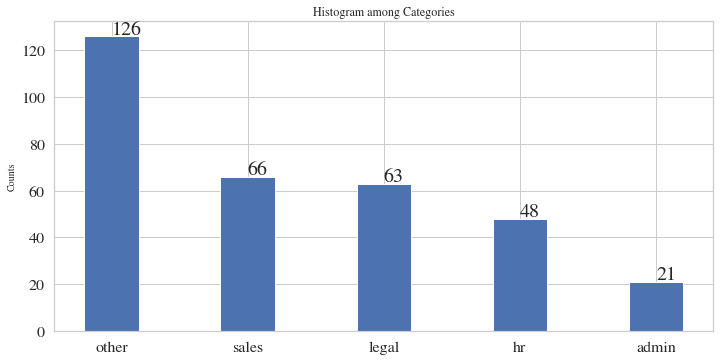

In [8]:
N = 5
menMeans = (20, 35, 30, 35, 27)
ind = np.arange(N)

#Creating a figure with some fig size
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(df.category.unique(),df.category.value_counts(),width=0.4)
#Now the trick is here.
#plt.text() , you need to give (x,y) location , where you want to put the numbers,
#So here index will give you x pos and data+1 will provide a little gap in y axis.
for index,data in enumerate(df.category.value_counts()):
    plt.text(x=index , y =data+1 ,  s=data, fontdict=dict(fontsize=20))
plt.tight_layout()
plt.ylabel('Counts')
plt.title('Histogram among Categories')
plt.show()

We have 324 documents which including 21 admin documents, 48 hr documents, 63 legal documents, 66 sales documents, 126 other documents. It seems that the labels are not balanced which might cause problems for the classification accuracy.

### 4.2  Relationship between Author and the Category
To check whether a certain author leads to a specific document class.

In [9]:
df[df.author.duplicated(keep=False)].sort_values('author')

,pagesCount,wordCount,fileSize,author,title,createdDate,category,label
134,38,26068,338884,Miss Jerri Larsen,limited liability company agreement,2019-09-02 10:30:36,legal,1
256,16,12752,127520,Miss Jerri Larsen,agreement terms,1994-04-08 10:30:51,legal,1
166,146,46866,187464,Miss Joann Osborn,managed services agreement,1996-03-14 22:01:08,sales,2
264,2,1094,6564,Miss Joann Osborn,important inform,2009-11-14 04:14:23,other,0
160,3,1509,10563,Mr Adan Wyatt,mining congo fiber,1999-07-09 02:38:23,other,0
84,21,3696,18480,Mr Adan Wyatt,individual employment agreement,2016-05-23 15:48:50,hr,3
142,2,904,5424,Mr Carlos Perez,johnny mathis privacy bahamas,1997-06-22 01:42:57,other,0
68,1397,582549,3495294,Mr Carlos Perez,header estimated billy ray cyrus medium,1982-11-12 10:33:09,other,0
132,11,1342,9394,Mr Cleveland Hammond,employment agr,1983-01-06 07:15:39,hr,3
294,61,8174,40870,Mr Cleveland Hammond,pric xl jerry falwel,1986-02-08 11:37:36,hr,3


Some authors have addressed docuemtns in different classes, like Miss Joann Osborn have created both sales and other documents while authors like Miss Jerri Larsen has only built single type of documents(legal).
Limited by data size, there is no enough evidence showing the relationship between author name and document category.

### 4.3 Relationship between Created date and the Category
To check whether a certain group of documents are created in a specific time.

In [10]:
type(df['createdDate'].dt.year)

pandas.core.series.Series

In [11]:
df['year'] = df['createdDate'].dt.year
df['month'] = df['createdDate'].dt.month
df['date'] = df['createdDate'].dt.day
df.head()

,pagesCount,wordCount,fileSize,author,title,createdDate,category,label,year,month,date
0,3,1350,9450,Mrs Jerri Larsen,turkey kingstown press,1982-10-13 20:54:49,other,0,1982,10,13
1,101,47975,335825,Ms Dee Tapia,managed services agr,2017-10-03 18:57:43,sales,2,2017,10,3
2,1537,833054,4165270,Mr Miquel Bond,x,1985-05-12 17:23:06,other,0,1985,5,12
3,13,8281,99372,Mr Darren Howell,energy legal mongolia,1997-01-28 17:42:34,legal,1,1997,1,28
4,1896,919560,4597800,Mr Modesto Watts,functional spec,2001-09-28 17:55:36,other,0,2001,9,28


In [12]:
df[['year','category','fileSize']].groupby(['year','category'])["fileSize"].count()

year  category
1981  hr          1
      legal       2
      other       2
      sales       1
1982  admin       1
      hr          1
      other       3
      sales       1
1983  admin       1
      hr          1
      legal       3
      other       4
      sales       2
1984  hr          2
      legal       1
      other       2
1985  legal       1
      other       4
      sales       2
1986  hr          3
      legal       1
      other       2
      sales       1
1987  admin       1
      hr          2
      legal       3
      other       1
1988  hr          1
      legal       4
      other       3
                 ..
2013  hr          1
      legal       3
      other       5
      sales       4
2014  admin       2
      hr          2
      legal       2
      other       5
      sales       2
2015  hr          1
      legal       1
      other       2
2016  admin       1
      hr          5
      legal       1
      other       4
      sales       1
2017  admin       1
     

In [13]:
df[['month','category','fileSize']].groupby(['month','category'])["fileSize"].count()

month  category
1      admin        1
       hr           5
       legal       12
       other       10
       sales        7
2      admin        1
       hr           4
       legal        6
       other       11
       sales        6
3      admin        2
       hr           6
       legal        8
       other       11
       sales        8
4      admin        1
       hr           6
       legal        5
       other       10
       sales        3
5      hr           3
       legal        4
       other       16
       sales        4
6      admin        3
       hr           4
       legal        4
       other        8
       sales       12
7      admin        1
       hr           1
       legal        4
       other       12
       sales        3
8      admin        1
       hr           3
       legal        6
       other        5
       sales        6
9      admin        5
       hr           5
       legal        4
       other        9
       sales        3
10     hr       

In [14]:
df[['date','category','fileSize']].groupby(['date','category'])["fileSize"].count()

date  category
1     hr          1
      other       4
      sales       2
2     hr          3
      legal       6
      other       3
      sales       6
3     legal       2
      other       4
      sales       2
4     admin       1
      hr          2
      legal       1
      other       2
      sales       2
5     admin       1
      hr          1
      legal       1
      other       4
      sales       1
6     admin       1
      hr          2
      legal       1
      other       3
7     hr          4
      legal       1
      other       2
      sales       3
8     admin       1
      hr          2
                 ..
24    other       3
      sales       2
25    hr          2
      legal       2
      other       6
      sales       2
26    legal       1
      other       8
      sales       3
27    admin       1
      hr          2
      other       4
      sales       2
28    admin       1
      hr          3
      legal       7
      other       3
      sales       1
29   

There is no obvious rules indicating the relationship between date and document category. We will abandon the "createdDate" feature in classifers training.

### 4.4 Title Length Distribution
Check the lenght of title string

The shortest and longest titles are 1 and 58


[Text(0,0.5,'Frequency'), Text(0.5,1,'Title Length Histogram')]

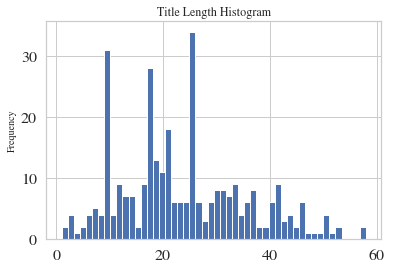

In [15]:
df['title_len']=df[['title']].applymap(len)
print('The shortest and longest titles are {} and {}'.format(df['title_len'].min(), df['title_len'].max()))
plt.hist(df.title_len,bins=50)
plt.gca().set(title='Title Length Histogram', ylabel='Frequency')

### 4.4 Wordcloud
WordCloud is a technique to show which words are the most frequent among the given text. It could help us find out the key words in the document title for a certain category like "legal". 

In [16]:
df_legal = df[df['category'].str.contains('legal')]
df_legal

,pagesCount,wordCount,fileSize,author,title,createdDate,category,label,year,month,date,title_len
3,13,8281,99372,Mr Darren Howell,energy legal mongolia,1997-01-28 17:42:34,legal,1,1997,1,28,21
6,32,22016,308224,Mrs Mary Moses,myanmar hi,1984-12-12 17:31:54,legal,1,1984,12,12,10
10,5,3695,44340,Ms Claire Kline,robert conrad health micronesia moroni,1996-11-19 15:35:34,legal,1,1996,11,19,41
13,15,9630,115560,Ms Leonor Ross,confidentiality agr,1996-01-13 00:37:05,legal,1,1996,1,13,19
14,15,9375,121875,Mrs Petra Colon,montenegro anthony geary footer san jose,2004-07-13 14:34:28,legal,1,2004,7,13,41
16,8,5032,70448,Miss Marilyn Knight,debate bottom america damascu,2002-02-16 23:36:38,legal,1,2002,2,16,30
24,13,8268,115752,Ms Chandra Pham,agreement terms,2009-01-21 22:50:14,legal,1,2009,1,21,16
34,37,27380,383320,Ms Brittany Pruitt,uruguay design,1989-04-13 14:54:17,legal,1,1989,4,13,14
36,22,17446,226798,Mrs Carla Leonard,math azerbaijan sukhumi xs,1988-12-03 03:13:09,legal,1,1988,12,3,27
40,24,15240,152400,Ms Clarissa Vaughn,world james franciscus congo,2019-03-13 12:08:59,legal,1,2019,3,13,29


In [17]:
excel_file = df_legal['title']
excel_file.to_csv('legal_text.txt', sep='\t', index=False)

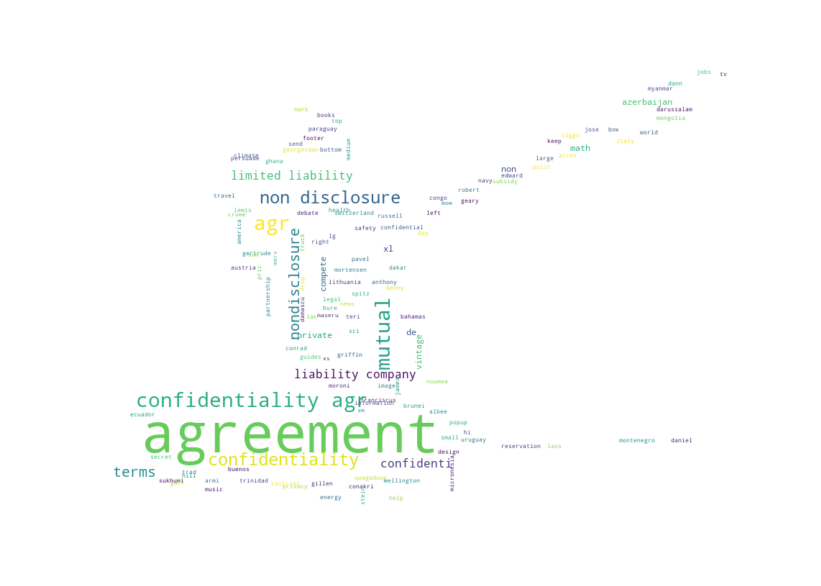

In [18]:
#coding=utf-8
#read a txt file
text = open('legal_text.txt', "r").read()
from PIL import Image
#load background picture
char_mask = np.array(Image.open("hammer.jpg"))
image_colors = ImageColorGenerator(char_mask)
my_wordcloud = WordCloud(scale=4,mask=char_mask,background_color='white',
                         max_words = 500,max_font_size = 20,random_state=20,min_font_size=1.5).generate(text) 

#show picture
plt.figure(figsize=(20,10))
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

#save image
# my_wordcloud.to_file('legal_result.jpg')

From the wordcloud above, it is obvious that words like agreement, confidentiality, non-disclosure, liability are most mentitioned in the document titles for legal category.

## 5. Model Selection
We will compare the accuracy of different Models (LSTM, SVM, Naive Bayes, MLP, KNN, Random Forest, Adaboost) with the steps:
- tokenize string features into vectors
- normalize numerical features
- combine text features and numerical features together as input
- grid search for parameter tunning
- compare the accuracy of training and test dataset

### 5.1 LSTM with Word2vec emmbeding

Word2vec is a simple two-layer neural networks which can trained to reconstruct linguistic contexts of words. It captures the position of the words in the text (syntactic)
and the meaning in the words (semantics). The title column of the dataset is limited and do not have the same structure and meaning. In this way, We use pretrained google's word2vec model which includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.It can be downloaded from https://github.com/mmihaltz/word2vec-GoogleNews-vectors. Word2vec only acts as an emmbeding layer in LSTM which do not affect the other models.

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.title)
X1 = tokenizer.texts_to_sequences(df.title)
tokenizer.fit_on_texts(df.author)
X2 = tokenizer.texts_to_sequences(df.author)
#X=  np.hstack((X1, X2))

In [20]:
maxlentitle = 10
#add padding
X1 = pad_sequences(X1, maxlen=maxlentitle)
print(X1.shape)


(324, 10)


In [21]:
df_num = df[['pagesCount', 'wordCount','fileSize']]
n_numerical_feats =3
n_steps=324
X_num = df_num.values
scaler = MinMaxScaler() 
X3 = scaler.fit_transform(X_num) 

In [22]:
merged =  np.hstack((X1,X2,X3))

In [23]:
### pre-trained google word2vec
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=50000)
#create a embedding layer using Google pre triained word2vec (50000 words)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=merged.shape[1])
#create model

lstm_out = 80

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 300)           15000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 15,093,765
Trainable params: 15,093,765
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
### one-hot encoder
labels = to_categorical(df['label'], num_classes=5)
print(labels[:10])

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(merged, labels, test_size= 0.25, random_state = 24)
epochs = 3
emb_dim = 128
batch_size = 256
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 194 samples, validate on 49 samples
Epoch 1/3
194/194 [==============================] - 2s 8ms/step - loss: 1.6173 - acc: 0.1753 - val_loss: 1.6058 - val_acc: 0.1224
Epoch 2/3
194/194 [==============================] - 0s 866us/step - loss: 1.6029 - acc: 0.2423 - val_loss: 1.5904 - val_acc: 0.3265
Epoch 3/3
194/194 [==============================] - 0s 874us/step - loss: 1.5922 - acc: 0.2629 - val_loss: 1.5754 - val_acc: 0.4898


In [26]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


81/81 [==============================] - 0s 195us/step
Test set
  Loss: 1.588
  Accuracy: 0.333


In [27]:
accr1 = model.evaluate(X_train,y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))


243/243 [==============================] - 0s 155us/step
Test set
  Loss: 1.579
  Accuracy: 0.395


In [28]:
lstm = {'name':['lstm'],'accuracy_train':[accr1[1]],'accuracy_test':[accr[1]]}
df_result = pd.DataFrame(lstm)

### 5.2 SVM

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(merged , df.label, test_size=0.25, random_state=42)

In [30]:

#params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10,100,1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
params_grid =[{'kernel': ['rbf'],'gamma': [1e-3],
                     'C': [1]}]
                    #{'kernel': ['linear'], 'C': [10]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train1, y_train1)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test1)
print("Training set score for SVM: %f" % final_model.score(X_train1 , y_train1))
print("Testing  set score for SVM: %f" % final_model.score(X_test1  , y_test1))
svm = {'name':'svm','accuracy_train':final_model.score(X_train1 , y_train1),'accuracy_test':final_model.score(X_test1  , y_test1)}
df_result= df_result.append(svm,ignore_index=True)

('Best score for training data:', 0.41975308641975306, '\n')
('Best C:', 1, '\n')
('Best Kernel:', 'rbf', '\n')
('Best Gamma:', 0.001, '\n')
Training set score for SVM: 0.954733
Testing  set score for SVM: 0.419753


/home/jfan/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 5.3 Naive Bayes Classifier

In [31]:
NB = MultinomialNB().fit(X_train1, y_train1)
#Y_pred = final_model.predict(X_test1)
print("Training set score for NB: %f" % NB.score(X_train1 , y_train1))
print("Testing  set score for NB: %f" % NB.score(X_test1  , y_test1))
nb = {'name':'naive bayes','accuracy_train':NB.score(X_train1 , y_train1),'accuracy_test':NB.score(X_test1  , y_test1)}
df_result= df_result.append(nb,ignore_index=True)

Training set score for NB: 0.230453
Testing  set score for NB: 0.246914


### 5.4 MLP

In [32]:

MLP = MLPClassifier(alpha=1, max_iter=1000).fit(X_train1, y_train1)
print("Training set score for MLP: %f" % MLP.score(X_train1 , y_train1))
print("Testing  set score for MLP: %f" % MLP.score(X_test1  , y_test1))
mlp = {'name':'mlp','accuracy_train':MLP.score(X_train1 , y_train1),'accuracy_test':MLP.score(X_test1 , y_test1)}
df_result= df_result.append(mlp,ignore_index=True)

Training set score for MLP: 0.617284
Testing  set score for MLP: 0.432099


### KNN

In [33]:

KNN =  KNeighborsClassifier(3).fit(X_train1, y_train1)
print("Training set score for KNN: %f" % KNN.score(X_train1 , y_train1))
print("Testing  set score for KNN: %f" % KNN.score(X_test1  , y_test1))
knn = {'name':'knn','accuracy_train':KNN.score(X_train1 , y_train1),'accuracy_test':KNN.score(X_test1 , y_test1)}
df_result= df_result.append(knn,ignore_index=True)

Training set score for KNN: 0.650206
Testing  set score for KNN: 0.345679


### 5.5 RandomForest

In [34]:

RF =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1).fit(X_train1, y_train1)
print("Training set score for RF: %f" % RF.score(X_train1 , y_train1))
print("Testing  set score for RF: %f" % RF.score(X_test1  , y_test1))
rf = {'name':'random forest','accuracy_train':RF.score(X_train1 , y_train1),'accuracy_test':RF.score(X_test1 , y_test1)}
df_result= df_result.append(rf,ignore_index=True)

Training set score for RF: 0.893004
Testing  set score for RF: 0.740741


### 5.6 Adaboost

In [36]:
AD = AdaBoostClassifier(n_estimators=20, learning_rate=3)
search_grid={'n_estimators':[10,100,1000],'learning_rate':[.001,0.01,.1,10]}
search=GridSearchCV(estimator=AD,param_grid=search_grid,scoring='accuracy',n_jobs=1,cv=5)
search.fit(X_train1, y_train1)
print search.best_params_

final_model = search.best_estimator_
Y_pred = final_model.predict(X_test1)
print("Training set score for AD: %f" % final_model.score(X_train1 , y_train1))
print("Testing  set score for AD: %f" % final_model.score(X_test1  , y_test1))
ad = {'name':'adaboost','accuracy_train':final_model.score(X_train1 , y_train1),'accuracy_test':final_model.score(X_test1 , y_test1)}
df_result= df_result.append(ad,ignore_index=True)
df_result

/home/jfan/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100, 'learning_rate': 0.001}
Training set score for AD: 0.798354
Testing  set score for AD: 0.740741


,accuracy_test,accuracy_train,name
0,0.333333,0.395062,lstm
1,0.419753,0.954733,svm
2,0.246914,0.230453,naive bayes
3,0.432099,0.617284,mlp
4,0.345679,0.650206,knn
5,0.740741,0.893004,random forest
6,0.740741,0.798354,adaboost
7,0.740741,0.798354,adaboost


The result dataframe illustrates that classifer Adaboost gains the best accuracy with both training data and test data. SVM, MLP, KNN, Random forest suffer from over-fiting while LSTM and Naive Bayes have similar low accuracy between training and test data. Neuarl Network like LSTM is more suitable for large dataset, limited by our data size, Adaboost is the most effient classifer compared with the others.

## 6. Model Evaluation

Based on the above comparision, we choose to use Adaboost model to generate our sorting app. Here gives the information of detailed model evaluation including confusion matrix, recall_score, f1 socre and feature importance.

### 6.1 Confusion Matrix

In [37]:
print ("confusion matrix for adabost: " )
confusion_matrix(y_test1, Y_pred)

confusion matrix for adabost: 


array([[33,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0],
       [ 0,  0, 13,  0,  0],
       [ 0, 11,  4,  0,  0],
       [ 0,  0,  6,  0,  0]])

### 6.2 Recall Score
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The best value is 1 and the worst value is 0. 'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [38]:
print ("recall score for adabost: " )
recall_score(y_test1, Y_pred, average='macro')

recall score for adabost: 


0.6

### 6.3 F1 Score
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [39]:
print ("f1 score for adabost: " )
f1_score(y_test1, Y_pred, average='macro')

f1 score for adabost: 


0.4880341880341881

### 6.4 Feature Importance

In [40]:
final_model.feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.88, 0.12, 0.  ])

The first 10 elements of the feature array are extracted from title, the middle 3 elements are extracted from author while the last 3 elements are representing the numerical features, pagecount, wordcount and filesize. It seems that the numerical featues contribute more to the model's predictive power.

## 7. Classification Application

The app takes 6 commond line inputs and outputs a prediction result

In [41]:
def document_classifer(pagesCount, wordCount, fileSize, author, title, createdDate):
    data= {'pagesCount':[pagesCount],'wordCount':[wordCount],'fileSize':[fileSize],'author':[author],'title':[title],'createdDate':[createdDate],'category':["legal"]}
    
    df_data = pd.DataFrame(data)
    df=pd.read_csv('t-data.csv')
    df= df.append(df_data,ignore_index=True)
    #print df_data
    df['author'] = df['author'].str.replace('.','')
    df['author'] = df['author'].str.replace('Mister','Mr')
    # change title to lowercase
    df['title']=df.title.str.lower()
    # remove non-alphabetic characters 

    df.title = df.title.apply(lambda x: re.sub('[^A-za-z]+', " ",  x))
    df['title'] = df['title'].str.replace('_',' ')
    ### Stemming
    porter = PorterStemmer()
    stem_title= df['title'].apply(lambda x: porter.stem(x))
    df['title']=stem_title
    ### Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatize_title= df['title'].apply(lambda x: lemmatizer.lemmatize(x))
    df['title'] = lemmatize_title
    #print df.tail()
    from keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df.title)
    #print df.title
    x1 = tokenizer.texts_to_sequences(df.title)
    tokenizer.fit_on_texts(df.author)
    x2 = tokenizer.texts_to_sequences(df.author)
    maxlentitle = 10
    #add padding
    x1 = pad_sequences(x1, maxlen=maxlentitle)
    num = df[['pagesCount', 'wordCount','fileSize']]
    x_num = num.values
    scaler = MinMaxScaler() 
    x3 = scaler.fit_transform(x_num)
    import numpy as np
    x =  np.hstack((x1,x2,x3))
    train_x = x[:-1]
    df['label']=0
    df.loc[df['category']=='other','label']=0
    df.loc[df['category']=='legal','label']=1
    df.loc[df['category']=='sales','label']=2
    df.loc[df['category']=='hr','label']=3
    df.loc[df['category']=='admin','label']=4
    labels = df.label
    train_labels = labels[:-1]
    X_train2, X_test2, y_train2, y_test2 = train_test_split(train_x , train_labels, test_size=0.25, random_state=42)
    print X_train2.shape
    print y_train2.shape
    ad = AdaBoostClassifier(n_estimators=100, learning_rate=.001).fit(X_train2, y_train2)
    y_pred = ad.predict(x[-1].reshape(1, -1))
    
    print y_pred
    if y_pred[0]==0:
        a = "other"
    elif y_pred[0]==1:
        a = "legal"
    elif y_pred[0]==2:
        a = "sales"
    elif y_pred[0]==3:
        a = "hr"
    elif y_pred[0]==4:
        a= "admin"
    print ('This document belongs to category:')
    return a


In [42]:
document_classifer(137,130424,1043392,"Miss Amelia Valenzuela","OFFICE LEASE AGREEMENT","2014-12-17T20:41:33.000Z")

(243, 16)
(243,)
[2]
This document belongs to category:


'sales'

In [43]:
document_classifer(143,134277,1074216,"Mr Chuck Rowland"," Lease â€“ Office","1996-12-21T06:45:29.000Z")

(243, 16)
(243,)
[2]
This document belongs to category:


'sales'

In [44]:
document_classifer(30,21930,241230,"Miss Cheri Wilkinson","CONFIDENTIALITY-NON-DISCLOSURE AND NON-COMPETE AGREEMENT","1996-12-21T06:45:29.000Z")

(243, 16)
(243,)
[1]
This document belongs to category:


'legal'

In [45]:
document_classifer(135,128250,897750,"Mrs. Jami Newton","Auckland Council","1996-09-27T11:57:39.000Z")

(243, 16)
(243,)
[2]
This document belongs to category:


'sales'

In [46]:
document_classifer(50,16600,116200,"Miss Natalie Gomez","Software as a Service Subscription Agreement","2013-04-11T04:49:53.000Z")


(243, 16)
(243,)
[2]
This document belongs to category:


'sales'

## 8. Limitations and Future Work

- Limited predictive accuracy. Limited by the size of meta dataset, the accuracy of the app is not that ideal. LSTM model could not play its magic. The accuracy could be imporved by fine parameter tunning, accurate feature selection(abandon unnecessary features), feature engeering (transform the format of the features, set thresholds and create dummies) etc.
- Poor model explanation. It is a little confusing that the feature importance shows the nummerical is more influencial than document titles. We could try to extract key words for each category and create dummy variables to make prediction.